# 

Brief 1-2 sentence description of notebook.

In [1]:
import os
import glob
import git
import sys


In [2]:
# Imports of all used packages and libraries
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [3]:
git_repo = git.Repo(".", search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

In [4]:
git_root

'/blue/npadillacoreano/ryoi360/projects/reward_comp/repos/social-neuro-modeling'

In [5]:
sys.path.insert(0, os.path.join(git_root, 'src'))

In [6]:
# sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

In [7]:
from utilities import helper

## Functions

In [15]:
def filter_spike_times(arr_2d, start, stop, padding=-1):
    """
    Filters a 2D array based on a start and stop condition and pads shorter arrays to match the length of the longest array.

    Parameters:
    arr_2d (numpy.ndarray): 2D array to be filtered and padded.
    start (int or float): Lower bound of the condition.
    stop (int or float): Upper bound of the condition.
    padding (int or float): Value to use for padding, defaults to -1.

    Returns:
    numpy.ndarray: A 2D array where each inner array has been filtered based on the condition and padded to match the length of the longest array.
    """

    # Filter each row in arr_2d based on the condition
    masked_data = [row[(row >= start) & (row < stop)] for row in arr_2d]

    # Determine the maximum length of arrays in the list
    max_length = max(len(arr) for arr in masked_data)

    # Pad each array in masked_data with the padding value so they all have the same length (max_length)
    padded_arrays = [np.concatenate([x, np.full([max_length - len(x)], padding)]) for x in masked_data]

    # Convert the list of arrays to a 2D numpy array
    padded_arrays = np.array(padded_arrays)

    return padded_arrays

## Inputs & Data

Explanation of each input and where it comes from.

In [8]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case

LFP_SPECTRAL_SLEAP_SPIKE_DF = pd.read_pickle("./spectral_preprocessing/proc/rce_pilot_2_05_lfp_spectral_sleap_spikes.pkl")


In [9]:
LFP_SPECTRAL_SLEAP_SPIKE_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port,recording_name,spike_clusters,spike_times,neuron_average_fr,neuron_average_timestamps
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[[24984, 31321], [39533, 39547], [39554, 39559...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,1.1,...,NaN,"[14.84, 13.97, 13.13, 12.32, 11.54, 10.78, 10....",NaN,"[25.6, 25.84, 25.86, 25.86, 25.86, 25.86, 25.8...",NaN,20230617_115521_standard_comp_to_omission_D1_s...,"[3, 4, 5, 6, 17, 28, 29, 39, 48, 52, 53, 54, 5...","[[673223.0, 2367433.0, 2569212.0, 3969647.0, 3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[[24984, 31321], [39533, 39547], [39554, 39559...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,1.1,...,"[[[40.039741738777444, 9.47029992556593], [42....","[8.96, 8.195, 7.54, 7.004, 6.605, 6.348, 6.227...","[11.19, 10.55, 9.92, 9.31, 8.734, 8.18, 7.64, ...","[11.19, 11.234, 11.73, 12.34, 12.56, 13.58, 13...","[25.6, 25.84, 25.86, 25.86, 25.86, 25.86, 25.8...",20230617_115521_standard_comp_to_omission_D1_s...,"[3, 4, 5, 6, 17, 28, 29, 39, 48, 52, 53, 54, 5...","[[673223.0, 2367433.0, 2569212.0, 3969647.0, 3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
2,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[[24984, 31321], [39533, 39547], [39554, 39559...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,1.2,...,"[[[57.86163468579171, 31.554562356382696], [59...","[11.19, 10.55, 9.92, 9.31, 8.734, 8.18, 7.64, ...","[8.96, 8.195, 7.54, 7.004, 6.605, 6.348, 6.227...","[25.6, 25.84, 25.86, 25.86, 25.86, 25.86, 25.8...","[11.19, 11.234, 11.73, 12.34, 12.56, 13.58, 13...",20230617_115521_standard_comp_to_omission_D1_s...,"[16, 17, 20, 25, 26, 34, 35, 39, 40, 42, 43, 4...","[[958.0, 5233.0, 6331.0, 7475.0, 8599.0, 10550...","[[1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
3,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...","[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...","[[0, 0], [0, 0], [0, 0], [0, 5], [12, 13], [13...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,1.2,...,NaN,"[5.184, 4.777, 4.383, 4.0, 3.629, 3.271, 2.926...",NaN,"[6.223, 6.227, 6.234, 6.24, 6.203, 6.2, 6.203,...",NaN,20230617_115521_standard_comp_to_omission_D1_s...,"[16, 17, 20, 25, 26, 34, 35, 39, 40, 42, 43, 4...","[[958.0, 5233.0, 6331.0, 7475.0, 8599.0, 10550...","[[1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
4,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...","[[33026, 33037], [33038, 33042], [33044, 33049...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,1.1,...,"[[[31.3

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

In [10]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = r"./proc/" # where data is saved should always be shown in the inputs
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_PREFIX = "rce_pilot_2"

# Documentation

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

In [11]:
LFP_SPECTRAL_SLEAP_SPIKE_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port,recording_name,spike_clusters,spike_times,neuron_average_fr,neuron_average_timestamps
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[[24984, 31321], [39533, 39547], [39554, 39559...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,1.1,...,NaN,"[14.84, 13.97, 13.13, 12.32, 11.54, 10.78, 10....",NaN,"[25.6, 25.84, 25.86, 25.86, 25.86, 25.86, 25.8...",NaN,20230617_115521_standard_comp_to_omission_D1_s...,"[3, 4, 5, 6, 17, 28, 29, 39, 48, 52, 53, 54, 5...","[[673223.0, 2367433.0, 2569212.0, 3969647.0, 3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[[24984, 31321], [39533, 39547], [39554, 39559...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,1.1,...,"[[[40.039741738777444, 9.47029992556593], [42....","[8.96, 8.195, 7.54, 7.004, 6.605, 6.348, 6.227...","[11.19, 10.55, 9.92, 9.31, 8.734, 8.18, 7.64, ...","[11.19, 11.234, 11.73, 12.34, 12.56, 13.58, 13...","[25.6, 25.84, 25.86, 25.86, 25.86, 25.86, 25.8...",20230617_115521_standard_comp_to_omission_D1_s...,"[3, 4, 5, 6, 17, 28, 29, 39, 48, 52, 53, 54, 5...","[[673223.0, 2367433.0, 2569212.0, 3969647.0, 3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
2,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[[24984, 31321], [39533, 39547], [39554, 39559...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,1.2,...,"[[[57.86163468579171, 31.554562356382696], [59...","[11.19, 10.55, 9.92, 9.31, 8.734, 8.18, 7.64, ...","[8.96, 8.195, 7.54, 7.004, 6.605, 6.348, 6.227...","[25.6, 25.84, 25.86, 25.86, 25.86, 25.86, 25.8...","[11.19, 11.234, 11.73, 12.34, 12.56, 13.58, 13...",20230617_115521_standard_comp_to_omission_D1_s...,"[16, 17, 20, 25, 26, 34, 35, 39, 40, 42, 43, 4...","[[958.0, 5233.0, 6331.0, 7475.0, 8599.0, 10550...","[[1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
3,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...","[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...","[[0, 0], [0, 0], [0, 0], [0, 5], [12, 13], [13...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,1.2,...,NaN,"[5.184, 4.777, 4.383, 4.0, 3.629, 3.271, 2.926...",NaN,"[6.223, 6.227, 6.234, 6.24, 6.203, 6.2, 6.203,...",NaN,20230617_115521_standard_comp_to_omission_D1_s...,"[16, 17, 20, 25, 26, 34, 35, 39, 40, 42, 43, 4...","[[958.0, 5233.0, 6331.0, 7475.0, 8599.0, 10550...","[[1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
4,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...","[[33026, 33037], [33038, 33042], [33044, 33049...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,1.1,...,"[[[31.3

## General

- Overall sampling rate is 20000Hz for ephys recording
    - Every data point has a corresponding "timestamps".
- Videos are recorded at around 30Hz
    - Each data point also has a corresponding "frame" that is determined by the frame that has the closest timestamp to to timestamp of the data point 
- Experiments are done in two operant chambers, "box_1" and "box_2"
    - Most competitions are done in box 1, and then one mice is separated out to box_2

In [18]:
LFP_SPECTRAL_SLEAP_SPIKE_DF.head()

,cohort,session_dir,tone_frames,box_1_port_entry_frames,box_2_port_entry_frames,video_name,session_path,recording,current_subject,subject,...,agent_locations,subject_thorax_velocity,agent_thorax_velocity,subject_thorax_to_reward_port,agent_thorax_to_reward_port,recording_name,spike_clusters,spike_times,neuron_average_fr,neuron_average_timestamps
0,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[[24984, 31321], [39533, 39547], [39554, 39559...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,1.1,...,NaN,"[14.84, 13.97, 13.13, 12.32, 11.54, 10.78, 10....",NaN,"[25.6, 25.84, 25.86, 25.86, 25.86, 25.86, 25.8...",NaN,20230617_115521_standard_comp_to_omission_D1_s...,"[3, 4, 5, 6, 17, 28, 29, 39, 48, 52, 53, 54, 5...","[[673223.0, 2367433.0, 2569212.0, 3969647.0, 3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
1,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[[24984, 31321], [39533, 39547], [39554, 39559...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.1,1.1,...,"[[[40.039741738777444, 9.47029992556593], [42....","[8.96, 8.195, 7.54, 7.004, 6.605, 6.348, 6.227...","[11.19, 10.55, 9.92, 9.31, 8.734, 8.18, 7.64, ...","[11.19, 11.234, 11.73, 12.34, 12.56, 13.58, 13...","[25.6, 25.84, 25.86, 25.86, 25.86, 25.86, 25.8...",20230617_115521_standard_comp_to_omission_D1_s...,"[3, 4, 5, 6, 17, 28, 29, 39, 48, 52, 53, 54, 5...","[[673223.0, 2367433.0, 2569212.0, 3969647.0, 3...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
2,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[1029, 1229], [3425, 3624], [5721, 5920], [75...","[[102, 105], [110, 148], [193, 199], [200, 202...","[[24984, 31321], [39533, 39547], [39554, 39559...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,1.2,...,"[[[57.86163468579171, 31.554562356382696], [59...","[11.19, 10.55, 9.92, 9.31, 8.734, 8.18, 7.64, ...","[8.96, 8.195, 7.54, 7.004, 6.605, 6.348, 6.227...","[25.6, 25.84, 25.86, 25.86, 25.86, 25.86, 25.8...","[11.19, 11.234, 11.73, 12.34, 12.56, 13.58, 13...",20230617_115521_standard_comp_to_omission_D1_s...,"[16, 17, 20, 25, 26, 34, 35, 39, 40, 42, 43, 4...","[[958.0, 5233.0, 6331.0, 7475.0, 8599.0, 10550...","[[1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
3,2,20230617_115521_standard_comp_to_omission_D1_s...,"[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...","[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0...","[[0, 0], [0, 0], [0, 0], [0, 5], [12, 13], [13...",20230617_115521_standard_comp_to_omission_D1_s...,/scratch/back_up/reward_competition_extention/...,20230617_115521_standard_comp_to_omission_D1_s...,1.2,1.2,...,NaN,"[5.184, 4.777, 4.383, 4.0, 3.629, 3.271, 2.926...",NaN,"[6.223, 6.227, 6.234, 6.24, 6.203, 6.2, 6.203,...",NaN,20230617_115521_standard_comp_to_omission_D1_s...,"[16, 17, 20, 25, 26, 34, 35, 39, 40, 42, 43, 4...","[[958.0, 5233.0, 6331.0, 7475.0, 8599.0, 10550...","[[1.0, 0.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0,...","[0, 2000, 4000, 6000, 8000, 10000, 12000, 1400..."
4,2,20230618_100636_standard_comp_to_omission_D2_s...,"[[1098, 1297], [3492, 3693], [5788, 5988], [75...","[[788, 835], [838, 839], [839, 871], [871, 900...","[[33026, 33037], [33038, 33042], [33044, 33049...",20230618_100636_standard_comp_to_omission_D2_s...,/scratch/back_up/reward_competition_extention/...,20230618_100636_standard_comp_to_omission_D2_s...,1.1,1.1,...,"[[[31.3

## Metadata

- `cohort`:
- `session_dir`:
- `tone_frames`:
- `box_1_port_entry_frames`:
- `box_2_port_entry_frames`:
- `video_name`:
- `session_path`:
- `recording`:
- `current_subject`:
- `subject`:
- `all_subjects`:
- `first_timestamp`:
- `last_timestamp`:
- `video_timestamps`:
- `tone_timestamps`:
- `box_1_port_entry_timestamps`:
- `box_2_port_entry_timestamps`:

## Z-scored local field potential values at 1000Hz
- http://www.scholarpedia.org/article/Local_field_potential
- `lfp_timestamps`:
- `mPFC_lfp_trace`:
- `MD_lfp_trace`:
- `LH_lfp_trace`:
- `BLA_lfp_trace`:
- `vHPC_lfp_trace`:

In [22]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["mPFC_lfp_trace"].iloc[0]

array([0.07367, 0.1105 , 0.19   , ..., 0.1163 , 0.3489 , 0.2732 ],
      dtype=float16)

In [24]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["lfp_timestamps"].iloc[0]

array([       0,       20,       40, ..., 79697440, 79697460, 79697480],
      dtype=int32)

In [23]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["mPFC_lfp_trace"].iloc[0].shape

(3984875,)

## Power spectra 
- Calculated with: https://spectral-connectivity.readthedocs.io/en/latest/examples/Intro_tutorial.html
- https://www.youtube.com/watch?v=Gka11q5VfFI
- 1 second window with 0.5 second window slides
- 1 Hz resolution(0 to 500Hz)
- `mPFC_power_all_frequencies_all_windows`:
- `MD_power_all_frequencies_all_windows`:
- `LH_power_all_frequencies_all_windows`:
- `BLA_power_all_frequencies_all_windows`:
- `vHPC_power_all_frequencies_all_windows`:
- `power_timestamps`:
- `power_calculation_frequencies`:

In [27]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["mPFC_power_all_frequencies_all_windows"].iloc[0]

array([[2.3697e-02, 1.2840e-02, 2.6825e-02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.6605e-03, 1.1192e-02, 3.7811e-02, ..., 1.7881e-07, 1.7881e-07,
        1.7881e-07],
       [2.3636e-02, 1.2474e-02, 1.3771e-02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [5.7404e-02, 3.0060e-02, 4.3427e-02, ..., 5.9605e-08, 5.9605e-08,
        5.9605e-08],
       [1.6953e-02, 1.7670e-02, 2.6306e-02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.0011e-03, 1.8860e-02, 2.3788e-02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], dtype=float16)

In [28]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["mPFC_power_all_frequencies_all_windows"].iloc[0].shape

(7968, 500)

In [29]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["power_calculation_frequencies"].iloc[0]

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [30]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["power_timestamps"].iloc[0]

array([   10000,    20000,    30000, ..., 79660000, 79670000, 79680000],
      dtype=int32)

## Coherence
- Calculated with: https://spectral-connectivity.readthedocs.io/en/latest/examples/Intro_tutorial.html
- https://www.youtube.com/watch?v=Gka11q5VfFI
- 1 second window with 0.5 second window slides
- 1 Hz resolution
- `BLA_LH_coherence_all_frequencies_all_windows`:
- `BLA_MD_coherence_all_frequencies_all_windows`:
- `BLA_mPFC_coherence_all_frequencies_all_windows`:
- `BLA_vHPC_coherence_all_frequencies_all_windows`:
- `LH_MD_coherence_all_frequencies_all_windows`:
- `LH_mPFC_coherence_all_frequencies_all_windows`:
- `LH_vHPC_coherence_all_frequencies_all_windows`:
- `MD_mPFC_coherence_all_frequencies_all_windows`:
- `MD_vHPC_coherence_all_frequencies_all_windows`:
- `mPFC_vHPC_coherence_all_frequencies_all_windows`:
- `coherence_timestamps`:
- `coherence_calculation_frequencies`:

In [31]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["BLA_LH_coherence_all_frequencies_all_windows"].iloc[0]

array([[0.116   , 0.34    , 0.4612  , ..., 0.8477  , 0.08636 , 0.496   ],
       [0.014435, 0.7935  , 0.866   , ..., 0.998   , 0.996   , 0.9927  ],
       [0.8755  , 0.827   , 0.888   , ..., 0.9795  , 0.995   , 0.9683  ],
       ...,
       [0.771   , 0.5415  , 0.6123  , ..., 0.9644  , 0.9336  , 0.966   ],
       [0.01491 , 0.9106  , 0.54    , ..., 0.8267  , 0.8633  , 0.907   ],
       [0.6284  , 0.8496  , 0.783   , ..., 0.955   , 0.951   , 0.9497  ]],
      dtype=float16)

In [32]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["BLA_LH_coherence_all_frequencies_all_windows"].iloc[0].shape

(7968, 500)

In [33]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["coherence_calculation_frequencies"].iloc[0]

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [34]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["coherence_timestamps"].iloc[0]

array([   10000,    20000,    30000, ..., 79660000, 79670000, 79680000],
      dtype=int32)

Granger's causality
- Calculated with: https://spectral-connectivity.readthedocs.io/en/latest/examples/Intro_tutorial.html
- https://www.youtube.com/watch?v=Gka11q5VfFI
- 1 second window with 0.5 second window slides
- 1 Hz resolution
- `BLA_LH_granger_all_frequencies_all_windows`:
- `LH_BLA_granger_all_frequencies_all_windows`:
- `BLA_MD_granger_all_frequencies_all_windows`:
- `MD_BLA_granger_all_frequencies_all_windows`:
- `BLA_mPFC_granger_all_frequencies_all_windows`:
- `mPFC_BLA_granger_all_frequencies_all_windows`:
- `BLA_vHPC_granger_all_frequencies_all_windows`:
- `vHPC_BLA_granger_all_frequencies_all_windows`:
- `LH_MD_granger_all_frequencies_all_windows`:
- `MD_LH_granger_all_frequencies_all_windows`:
- `LH_mPFC_granger_all_frequencies_all_windows`:
- `mPFC_LH_granger_all_frequencies_all_windows`:
- `LH_vHPC_granger_all_frequencies_all_windows`:
- `vHPC_LH_granger_all_frequencies_all_windows`:
- `MD_mPFC_granger_all_frequencies_all_windows`:
- `mPFC_MD_granger_all_frequencies_all_windows`:
- `MD_vHPC_granger_all_frequencies_all_windows`:
- `vHPC_MD_granger_all_frequencies_all_windows`:
- `mPFC_vHPC_granger_all_frequencies_all_windows`:
- `vHPC_mPFC_granger_all_frequencies_all_windows`:
- `granger_timestamps`:
- `granger_calculation_frequencies`:



In [35]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["BLA_LH_coherence_all_frequencies_all_windows"].iloc[0]

array([[0.116   , 0.34    , 0.4612  , ..., 0.8477  , 0.08636 , 0.496   ],
       [0.014435, 0.7935  , 0.866   , ..., 0.998   , 0.996   , 0.9927  ],
       [0.8755  , 0.827   , 0.888   , ..., 0.9795  , 0.995   , 0.9683  ],
       ...,
       [0.771   , 0.5415  , 0.6123  , ..., 0.9644  , 0.9336  , 0.966   ],
       [0.01491 , 0.9106  , 0.54    , ..., 0.8267  , 0.8633  , 0.907   ],
       [0.6284  , 0.8496  , 0.783   , ..., 0.955   , 0.951   , 0.9497  ]],
      dtype=float16)

In [41]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["BLA_LH_coherence_all_frequencies_all_windows"].iloc[0].shape

(7968, 500)

In [40]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["granger_calculation_frequencies"].iloc[0]

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [39]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["granger_timestamps"].iloc[0]

array([   10000,    20000,    30000, ..., 79660000, 79670000, 79680000],
      dtype=int32)

## Theta and Gamma filtered power, cohernce, and Granger's causality
- Similar to power, coherence, and Granger's as before but all values in Theta band (4~12Hz) and Gamma (30~50Hz) band have been filtered out and averaged. 
- `mPFC_power_theta`:
- `mPFC_power_gamma`:
- `MD_power_theta`:
- `MD_power_gamma`:
- `LH_power_theta`:
- `LH_power_gamma`:
- `BLA_power_theta`:
- `BLA_power_gamma`:
- `vHPC_power_theta`:
- `vHPC_power_gamma`:
- `BLA_LH_coherence_theta`:
- `BLA_LH_coherence_gamma`:
- `BLA_MD_coherence_theta`:
- `BLA_MD_coherence_gamma`:
- `BLA_mPFC_coherence_theta`:
- `BLA_mPFC_coherence_gamma`:
- `BLA_vHPC_coherence_theta`:
- `BLA_vHPC_coherence_gamma`:
- `LH_MD_coherence_theta`:
- `LH_MD_coherence_gamma`:
- `LH_mPFC_coherence_theta`:
- `LH_mPFC_coherence_gamma`:
- `LH_vHPC_coherence_theta`:
- `LH_vHPC_coherence_gamma`:
- `MD_mPFC_coherence_theta`:
- `MD_mPFC_coherence_gamma`:
- `MD_vHPC_coherence_theta`:
- `MD_vHPC_coherence_gamma`:
- `mPFC_vHPC_coherence_theta`:
- `mPFC_vHPC_coherence_gamma`:
- `BLA-to-LH_granger_theta`:
- `BLA-to-LH_granger_gamma`:
- `LH-to-BLA_granger_theta`:
- `LH-to-BLA_granger_gamma`:
- `BLA-to-MD_granger_theta`:
- `BLA-to-MD_granger_gamma`:
- `MD-to-BLA_granger_theta`:
- `MD-to-BLA_granger_gamma`:
- `BLA-to-mPFC_granger_theta`:
- `BLA-to-mPFC_granger_gamma`:
- `mPFC-to-BLA_granger_theta`:
- `mPFC-to-BLA_granger_gamma`:
- `BLA-to-vHPC_granger_theta`:
- `BLA-to-vHPC_granger_gamma`:
- `vHPC-to-BLA_granger_theta`:
- `vHPC-to-BLA_granger_gamma`:
- `LH-to-MD_granger_theta`:
- `LH-to-MD_granger_gamma`:
- `MD-to-LH_granger_theta`:
- `MD-to-LH_granger_gamma`:
- `LH-to-mPFC_granger_theta`:
- `LH-to-mPFC_granger_gamma`:
- `mPFC-to-LH_granger_theta`:
- `mPFC-to-LH_granger_gamma`:
- `LH-to-vHPC_granger_theta`:
- `LH-to-vHPC_granger_gamma`:
- `vHPC-to-LH_granger_theta`:
- `vHPC-to-LH_granger_gamma`:
- `MD-to-mPFC_granger_theta`:
- `MD-to-mPFC_granger_gamma`:
- `mPFC-to-MD_granger_theta`:
- `mPFC-to-MD_granger_gamma`:
- `MD-to-vHPC_granger_theta`:
- `MD-to-vHPC_granger_gamma`:
- `vHPC-to-MD_granger_theta`:
- `vHPC-to-MD_granger_gamma`:
- `mPFC-to-vHPC_granger_theta`:
- `mPFC-to-vHPC_granger_gamma`:
- `vHPC-to-mPFC_granger_theta`:
- `vHPC-to-mPFC_granger_gamma`:


In [42]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["mPFC_power_theta"].iloc[0]

array([0.06213 , 0.05728 , 0.04642 , ..., 0.03845 , 0.01386 , 0.007584],
      dtype=float16)

In [43]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["mPFC_power_theta"].iloc[0].shape

(7968,)

## SLEAP pose tracking
- Start and stop frame of the video where the subject is in the video
    - `start_frame`:
    - `stop_frame`:
- Subjects that are being pose tracked
    - `tracked_subject`:
- All subjects in the video
    - `in_video_subjects`:
- The number of the box that the video was being taken from
    - `box_number`:
- Name of the sleap file    
    - `sleap_name`:
- The order of the body parts that are being tracked
    - `body_parts`:
- Coordinates of the boxes
    - `box_top_left`:
    - `box_top_right`:
    - `reward_port`:
    - `box_bottom_left`:
    - `box_bottom_right`:
- The ID of the agent if there is any
    - `agent`:
- The pose tracking of the subject and agent. With shapes: `(Frame number, body part, x and y coordinate)`
    - `subject_locations`:
    - `agent_locations`:
- The velocity of the thorax
    - `subject_thorax_velocity`:
    - `agent_thorax_velocity`:
- The distance of the mice from the reward port
    - `subject_thorax_to_reward_port`:
    - `agent_thorax_to_reward_port`:
    - `recording_name`:


In [56]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["body_parts"].iloc[0]

['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']

In [58]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["subject_locations"].iloc[0].shape

(79051, 6, 2)

In [60]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["subject_locations"].iloc[0][:5]

array([[[40.03974174,  9.47029993],
        [42.2344355 , 11.20484943],
        [43.33928086, 10.15233036],
        [35.02387486, 14.44690443],
        [37.69112909, 11.92069805],
        [42.23403293, 10.15560326]],

       [[40.05277666,  9.44590655],
        [42.26265383, 11.18930935],
        [43.33545005, 10.11239413],
        [35.00913006, 14.1712644 ],
        [37.71427922, 11.64648991],
        [42.22566787, 10.13336395]],

       [[40.0431276 ,  9.43675057],
        [42.25591601, 11.18617742],
        [43.33997583, 10.12077335],
        [35.00047895, 14.16977998],
        [37.71065605, 11.63882733],
        [42.23404141, 10.12650094]],

       [[40.03724154,  9.44154797],
        [42.24636441, 11.18527143],
        [43.31990222, 10.11965728],
        [35.01566659, 14.17604522],
        [37.70388009, 11.6418321 ],
        [42.21804862, 10.12763498]],

       [[40.05512007,  9.45033354],
        [42.2531785 , 11.20581486],
        [43.37004175, 10.15311541],
        [35.01666031

## Spikes
- The ID of each unit/neuron
    - `spike_clusters`:
- The times that each spike fired for each neuron. Each row is a neuron and a `-1` timestamp is to pad the Numpy array and is not a spike time.
    - `spike_times`:
- The firing rate averaged
    - `neuron_average_fr`:
- The timestamps of the neuron firing rate averages 
    - `neuron_average_timestamps`:

In [61]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["spike_clusters"].iloc[0]

[3, 4, 5, 6, 17, 28, 29, 39, 48, 52, 53, 54, 59, 60, 74, 78, 79, 80]

In [63]:
len(LFP_SPECTRAL_SLEAP_SPIKE_DF["spike_clusters"].iloc[0])

18

In [64]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["neuron_average_fr"].iloc[0]

array([[0., 0., 0., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(array([3.7837e+04, 1.6440e+03, 2.2600e+02, 1.0100e+02, 3.0000e+01,
        5.0000e+00, 4.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

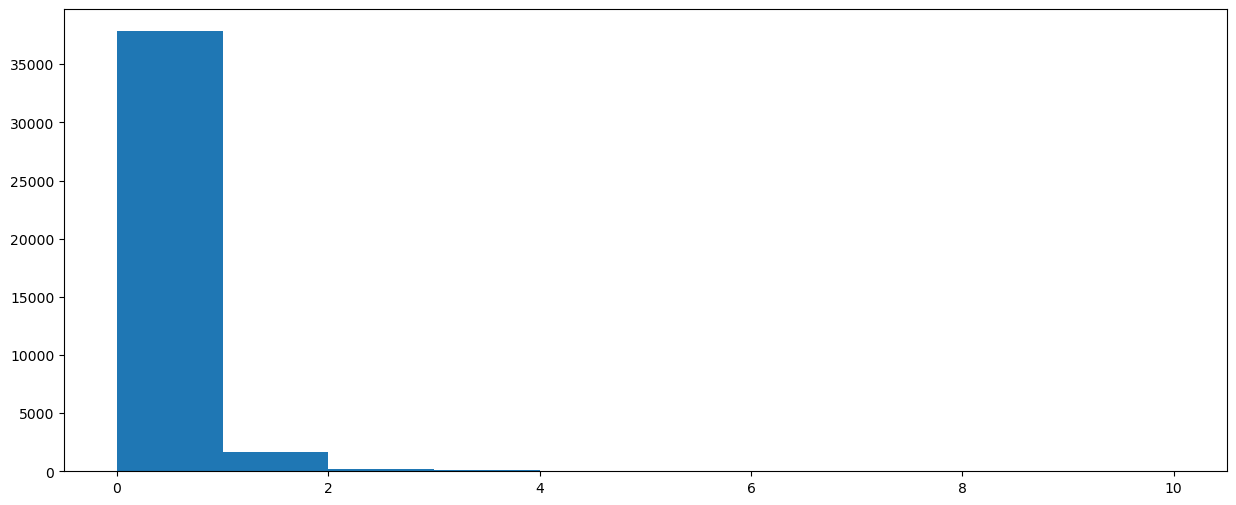

In [71]:
plt.hist(LFP_SPECTRAL_SLEAP_SPIKE_DF["neuron_average_fr"].iloc[0][0])

In [65]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["neuron_average_fr"].iloc[0].shape

(18, 39849)

In [66]:
LFP_SPECTRAL_SLEAP_SPIKE_DF["neuron_average_timestamps"].iloc[0].shape

(39849,)

## Example filtering

- Get a range of timestamps or frames

In [74]:
example_tone_timestamp_range = LFP_SPECTRAL_SLEAP_SPIKE_DF["tone_timestamps"].iloc[0][0]

In [75]:
example_tone_timestamp_range

array([1030879, 1230878], dtype=int32)

- Get a list of the timestamps of the data

In [76]:
example_timestamps = LFP_SPECTRAL_SLEAP_SPIKE_DF["video_timestamps"].iloc[0]

In [77]:
example_timestamps.shape

(79051,)

In [78]:
example_timestamps

array([      -2,     1384,     1500, ..., 79697199, 79698585, 79699971],
      dtype=int32)

- Get the data

In [79]:
example_poses = LFP_SPECTRAL_SLEAP_SPIKE_DF["subject_locations"].iloc[0]

In [80]:
example_poses.shape

(79051, 6, 2)

- Filter with function

In [81]:
filtered_timestamps, filtered_items = helper.filter_by_timestamp_range(start=example_tone_timestamp_range[0], 
                                 stop=example_tone_timestamp_range[1],
                                timestamps=example_timestamps,
                                items=example_poses)

- Timestamps that are within the specified range

In [84]:
filtered_timestamps.shape

(200,)

In [85]:
filtered_items.shape

(200, 6, 2)

In [82]:
filtered_timestamps

array([1031085, 1032471, 1032471, 1033857, 1035243, 1036629, 1036629,
       1038014, 1039400, 1040786, 1040786, 1042172, 1043558, 1044944,
       1044944, 1046330, 1047716, 1047716, 1049101, 1050487, 1050487,
       1051873, 1053259, 1054645, 1054645, 1056031, 1057417, 1057417,
       1058802, 1060188, 1061574, 1061574, 1062960, 1064346, 1065732,
       1065732, 1067118, 1068504, 1069889, 1069889, 1071275, 1072661,
       1072661, 1074047, 1075433, 1076819, 1076819, 1078205, 1079591,
       1079591, 1080976, 1082362, 1083748, 1083748, 1085134, 1086520,
       1086643, 1087906, 1089292, 1090677, 1091384, 1092063, 1093449,
       1094835, 1094835, 1096221, 1097607, 1098993, 1098993, 1100379,
       1101764, 1101764, 1103150, 1104536, 1105922, 1105922, 1107308,
       1108694, 1108694, 1110080, 1111466, 1112262, 1112851, 1114237,
       1115623, 1116321, 1117009, 1118395, 1119781, 1119781, 1121167,
       1122552, 1123938, 1123938, 1125324, 1126710, 1126710, 1128096,
       1129482, 1130

In [83]:
filtered_items

array([[[47.29289684, 35.53693675],
        [44.93394439, 34.46108232],
        [44.98054127, 36.94402084],
        [52.7640135 , 32.21176127],
        [48.93075444, 33.30786957],
        [45.49551397, 35.91997452]],

       [[47.19059642, 35.52335308],
        [44.48753217, 34.73537891],
        [44.94423333, 36.95460526],
        [52.74707149, 32.21894287],
        [48.9127615 , 33.30526009],
        [45.01937907, 36.20157157]],

       [[47.15187303, 35.52160882],
        [44.46342858, 34.74615683],
        [44.92953726, 36.96004536],
        [52.7418804 , 32.22663309],
        [48.89181494, 33.30638791],
        [44.99336855, 36.20372494]],

       ...,

       [[51.61980064, 36.95611179],
        [51.05446805, 35.16747158],
        [48.33860618, 35.87138956],
        [58.24330029, 32.9066456 ],
        [55.57545915, 34.82275499],
        [49.45220223, 35.89884438]],

       [[51.62592824, 36.95395842],
        [51.0571886 , 35.16309296],
        [48.34398796, 35.87054369],
       